# Estudo de crescimento e produção

Os estudos de crescimento e produção buscam entender o desenvolvimento e a produtividade de plantios florestais. Esses estudos abordam aspectos como:

* Taxa de crescimento: Variação do crescimento das árvores ao longo do tempo.
* Produção: Produção da florsta ao longo do tempo.
* Fatores ambientais: Identificação de fatores que afetam o crescimento (clima, solo, nutrientes, etc.).
* Modelagem de crescimento: Desenvolvimento de modelos matemáticos para prever o crescimento.

Estudos de crescimento e produção precisam levar em consideração diversas disciplinas como:

* Silvicultura
* Ecologia florestal
* Economia florestal
* Biometria
* Sensoriamento remoto
* Modelagem computacional

Esses estudos são fundamentais para o desenvolvimento de práticas de manejo florestal sustentáveis e eficientes. Antes de avançar na leitura, é importante conhecer alguns conceitos básicos:

Link: [Conceitos-chave](https://airtable.com/app1KEkjr2v36cmqd/shrHWKqlXJJ7N8qp8)

# Preparação do ambiente R


In [1]:
install.packages("forestmangr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘zoo’, ‘xts’, ‘SparseM’, ‘MatrixModels’, ‘mvtnorm’, ‘TH.data’, ‘numDeriv’, ‘doBy’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘bitops’, ‘lmtest’, ‘sandwich’, ‘ggpp’, ‘confintr’, ‘polynom’, ‘quantreg’, ‘lmodel2’, ‘splus2R’, ‘multcomp’, ‘multcompView’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘lme4’, ‘reshape2’, ‘RCurl’, ‘ggthemes’, ‘plyr’, ‘systemfit’, ‘ggpmisc’, ‘car’, ‘minpack.lm’, ‘FinCal’, ‘ggdendro’, ‘gridExtra’




In [2]:
library(forestmangr)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Estudos de crescimento demandam informações ao longo do tempo. Embora estudos de dencrocronologia também possam ser utilizados, o mais comum no Brasil é a utilização de dados provenientes de inventário contínuo. Um inventário florestal contínuo é um método sistemático de coleta de dados sobre as florestas ao longo do tempo. O inventário florestal contínuo é ideal para acompanhar e monitorar as mudanças na floresta. Isso permite uma compreensão mais aprofundada da dinâmica florestal, incluindo crescimento, mortalidade, e regeneração de árvores.

Os inventários florestais contínuos permitem o monitoramento regular do crescimento e mortalidade das árvores. Desta forma, é possivel avaliar a produção de biomassa, análisar os impactos de fatores ambientais, atividades silviculturais, pragas e doenças. Com dados atualizados, os gestores podem tomar decisões informadas para planejamento silvicultural, manejo e colheita.

In [4]:
inventario <- read_csv('inventario.csv')

Rows: 1842 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): CLONE, ESPECIE, ESPAC
dbl (16): FAZENDA, TALHAO, PARCELA, IDADE, IDADE_MES, MED, Q, DAP, HT, HD, B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
inventario <- inventario %>%
  mutate(chave = paste0(FAZENDA, TALHAO, PARCELA))

head(inventario)

FAZENDA,TALHAO,PARCELA,CLONE,IDADE,IDADE_MES,MED,Q,DAP,HT,HD,B,VCCT,VCST,VCCC,VCSC,FUSTES,ESPECIE,ESPAC,chave
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,23,1,0003,2.26,27,1,9.96,9.78,15.08,16.80,8.78,66.30,51.50,57.23,44.65,1127,GRD,"3,00x3,00",1231
1,23,1,0003,3.01,36,2,11.32,11.09,18.10,20.90,11.34,106.45,85.10,96.47,77.54,1127,GRD,"3,00x3,00",1231
1,23,1,0003,3.93,47,3,11.85,11.58,20.01,23.33,12.43,132.30,106.91,122.05,99.09,1127,GRD,"3,00x3,00",1231
1,23,1,0003,5.01,60,4,12.99,12.62,21.74,25.42,14.95,170.44,140.49,161.06,133.29,1127,GRD,"3,00x3,00",1231
1,23,1,0003,6.01,72,5,13.28,12.89,22.97,27.13,15.61,190.43,157.63,180.87,150.26,1127,GRD,"3,00x3,00",1231
1,23,1,0003,7.01,84,6,13.85,13.38,24.94,30.00,17.00,230.07,192.22,220.36,184.72,1127,GRD,"3,00x3,00",1231


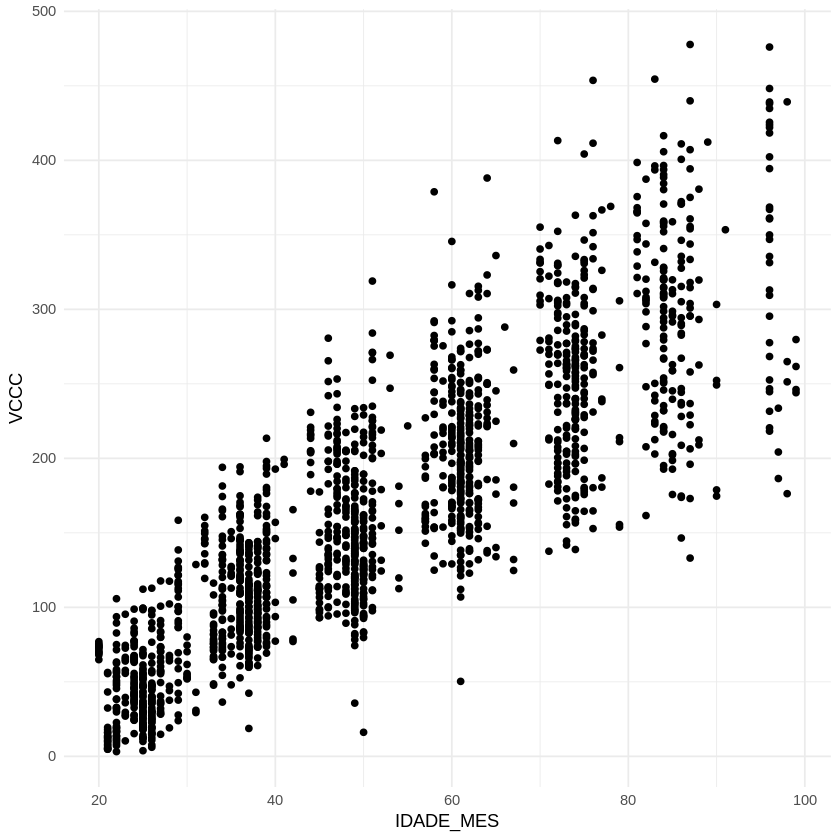

In [6]:
inventario %>%
  ggplot() +
    geom_point(aes(IDADE_MES, VCCC)) +
    theme_minimal()

# Modelos de crescimento e produção em nível de povoamento

## Modelos que diferenciam a idade

Os modelos mais simples consideram que apenas a idade das árvores (I) são preditoras da produção (V). O crescimento de árvores experimentam um crescimento inicial rápido seguido de desaceleração mais acentuada. Para representar esta forma, utiliza-se geralmente funções não-lineres como por exemplo:

$V = exp(\beta_0 + \beta_1 * \frac{1}{I})$



In [7]:
mcp_i <- inventario %>%
  lm_table(log(VCCC) ~ inv(IDADE_MES))

mcp_i

b0,b1,Rsqr,Rsqr_adj,Std.Error
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6.400615,-65.78797,0.7363051,0.7361618,0.3923655


Existem ainda modelos que carregam inúmeras propriedades matemáticas como o modelo de Chapaman-Richards:

$VCCC = \beta_0 * (1-e^{(-\beta_1* I)})^{\beta_2}$

In [8]:
mcp_i2 = inventario %>%
  nls_table(VCCC ~ b0 * (1-exp(-b1* IDADE_MES))^b2, mod_start = c( b0=200, b1=0.03, b2 = 1.3))

mcp_i2

b0,b1,b2
<dbl>,<dbl>,<dbl>
455.9491,0.02033032,2.282124


## Modelos que diferenciam a idade e a capacidade produtiva

Os modelos de crescimento e produção florestal que incorporam tanto a idade das árvores quanto a capacidade de sítio (a qualidade do local onde as árvores estão crescendo) argumentam que além da idade, a capacidade de sítio influencia o desenvolvimento da floresta, e que portanto, sua inclusão permite diferenciar o crescimento em diferentes realidades.

$V = exp(\beta_0 + \beta_1 \frac{1}{I*S})$

In [9]:
idade_indice <- 60
inventario <- inventario %>%
  lm_table(log(HD) ~ inv(IDADE_MES),
            output = "merge" ) %>%
  mutate(S = exp(log(HD) - b1 * (inv(IDADE_MES) - inv(idade_indice))))

In [10]:
mcp_is <- inventario %>%
  lm_table(log(VCCC) ~ inv(IDADE_MES * S))

mcp_is

b0,b1,Rsqr,Rsqr_adj,Std.Error
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6.467053,-1777.049,0.919468,0.9194242,0.2168324


## Modelos que diferenciam a idade, a capacidade produtiva e ocupação da área

Existem modelos de crescimento e produção mais sofisticados que consideram além da capacidade produtiva e da idade, uma métrica de ocupação (~ densidade de árvores por hectare). O modelo mais usado no setor de floretas plantadas é o modelo de Clutter. Ele é composto por um sistema de equações. Uma para estimar a área basal em função da idade, e outra para estimar a produção em função da idade, capacidade produtiva e área basal.

$ln(V) = \beta_0 + \beta_1 \frac{1}{I_2} + \beta_2 S + \beta_3 ln(B_2)$

$ln(B_2) = ln(B_1) \frac{I_1}{I_2} + \alpha_0 (1 - \frac{I_1}{I_2}) + \alpha_1 (1 - \frac{I_1}{I_2}) S$

In [11]:
coefs_clutter <- fit_clutter(inventario, "IDADE_MES", "HD", "B",
  "VCCC", "S", "chave")
coefs_clutter

b0,b1,b2,b3,a0,a1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.037271,-25.47046,0.01785776,1.096283,4.276515,-0.02853486


# Idade técnica de corte

A idade técnica de corte ocorre no ponto de máximo incremento médio anual (IMA). Este ponto pode ser analiticamente determinado pelo cruzamento da curva de incremento corrente anual (ICA) com a curva do incremento médio (IMA).

A ITC também pode ser determinada de forma algébrica, igualando as expressões do volume médio e do volume corrente:

$\frac{V}{I} = \frac{dV}{dI}$

## ITC no modelo apenas com I

Considerando o modelo:

$V = exp(\beta_0 + \beta_1 * \frac{1}{I})$

De forma algébrica tem-se que:

$ITC = -\beta_1$



Veja a demonstração matemática desta derivação em: [Derivando com WorlframAlpha](https://www.wolframalpha.com/input?i=d%2Fdx+%28exp%28%5Cbeta_0+%2B+%5Cbeta_1+%5Cfrac%7B1%7D%7Bx%7D%29%29+%3D+%28exp%28%5Cbeta_0+%2B+%5Cbeta_1+%5Cfrac%7B1%7D%7Bx%7D%29%2Fx%29)

## ITC no modelo com I e S

Considerando o modelo:

$V = exp(\beta_0 + \beta_1 * \frac{1}{I * S})$

De forma algébrica tem-se que:

$ITC = \frac{-\beta_1}{S}$

Veja a demonstração matemática desta derivação em: [Derivando com WorlframAlpha](https://www.wolframalpha.com/input?i=d%2Fdx+%28exp%28%5Cbeta_0+%2B+%5Cbeta_1+%5Cfrac%7B1%7D%7Bx*S%7D%29%29+%3D+%28exp%28%5Cbeta_0+%2B+%5Cbeta_1+%5Cfrac%7B1%7D%7Bx*S%7D%29%2Fx%29)

## ITC no modelo com B, S e I

Nem sempre, é possível determinar a idade técnica de corte utilizando o cálculo diferencial. No caso do modelo de Clutter, determinar a ITC de forma analítica é mais simples. Assim, aplica-se o modelo em valores médios para cada classe de capacidade produtiva e determinam-se as curvas de crescimento corrente e crescimento médio. O local em que estas duas curvas se encontram, indicam a idade técnica de corte.

In [12]:
inventario_classes <- classify_site(inventario, "S", 3, "chave")

In [13]:
head(inventario_classes)

,chave,site_mean,FAZENDA,TALHAO,PARCELA,CLONE,IDADE,IDADE_MES,MED,Q,⋯,ESPAC,b0,b1,Rsqr,Rsqr_adj,Std.Error,S,interval,category,category_
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,922261,17.8044,9,22,261,0459,2.11,25,1,7.83,⋯,"3,50x2,60",3.6956,-25.9936,0.8235,0.8234,0.1199,13.9387,23.01543,1,Lower
2,922261,17.8044,9,22,261,0459,3.11,37,2,10.48,⋯,"3,50x2,60",3.6956,-25.9936,0.8235,0.8234,0.1199,18.3267,23.01543,1,Lower
3,922261,17.8044,9,22,261,0459,4.11,49,3,12.17,⋯,"3,50x2,60",3.6956,-25.9936,0.8235,0.8234,0.1199,19.8385,23.01543,1,Lower
4,922261,17.8044,9,22,261,0459,5.11,61,4,13.62,⋯,"3,50x2,60",3.6956,-25.9936,0.8235,0.8234,0.1199,19.1138,23.01543,1,Lower
5,927269,19.4013,9,27,269,0459,2.13,26,1,7.11,⋯,"3,50x2,60",3.6956,-25.9936,0.8235,0.8234,0.1199,13.4451,23.01543,1,Lower
6,927269,19.4013,9,27,269,0459,3.13,38,2,11.45,⋯,"3,50x2,60",3.6956,-25.9936,0.8235,0.8234,0.1199,22.8100,23.01543,1,Lower


In [14]:
inventario_classes_clutter <- est_clutter(inventario_classes, 20:125, "B",
  "S", "category_", coefs_clutter)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


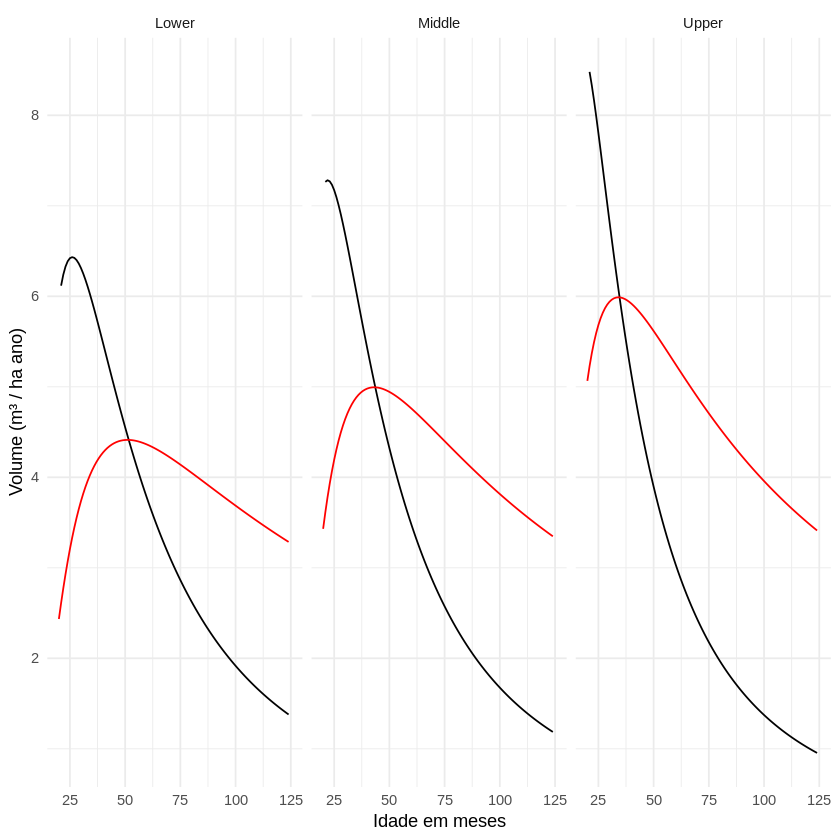

In [16]:
inventario_classes_clutter %>%
  ggplot() + geom_line(aes(Age, CMI)) +
    geom_line(aes(Age, MMI), colour = 'red') +
    ylab('Volume (m³ / ha ano)') + xlab('Idade em meses') +
    facet_grid(col = vars(category_)) +
    theme_minimal()

Para mais detalhes leia: [Mensuração Florestal por Carlos Pedro Boechat](https://www.mensuracaoflorestal.com.br/modelos-em-nivel-de-povoamento)